[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/generation/langchain/handbook/xx-langchain-chunking.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/generation/langchain/handbook/xx-langchain-chunking.ipynb)

#### [LangChain Handbook](https://pinecone.io/learn/langchain)

# Preparing Text Data for use with Retrieval-Augmented LLMs

In this walkthrough we'll take a look at an example and some of the considerations when we need to prepare text data for retrieval augmented question-answering using **L**arge **L**anguage **M**odels (LLMs).

## Required Libraries

There are a few Python libraries we must `pip install` for this notebook to run, those are:

In [ ]:
!pip install -qU langchain tiktoken matplotlib seaborn tqdm

## Preparing Data

In this example, we will download the LangChain docs from [langchain.readthedocs.io/](https://langchain.readthedocs.io/latest/en/). We get all `.html` files located on the site like so:

In [ ]:
!wget -r -A.html -P rtdocs https://langchain.readthedocs.io/en/latest/

This downloads all HTML into the `rtdocs` directory. Now we can use LangChain itself to process these docs. We do this using the `ReadTheDocsLoader` like so:

In [44]:
from langchain.document_loaders import ReadTheDocsLoader

loader = ReadTheDocsLoader('rtdocs')
docs = loader.load()
len(docs)

c:\Users\matte\miniconda3\envs\ml\lib\site-packages\langchain\document_loaders\readthedocs.py:30: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 30 of the file c:\Users\matte\miniconda3\envs\ml\lib\site-packages\langchain\document_loaders\readthedocs.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  _ = BeautifulSoup(
c:\Users\matte\miniconda3\envs\ml\lib\site-packages\langchain\document_loaders\readthedocs.py:46: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another sys

397

This leaves us with `389` processed doc pages. Let's take a look at the format each one contains:

In [4]:
docs[0]

Document(page_content='.md\n.pdf\nDeployments\n Contents \nStreamlit\nGradio (on Hugging Face)\nBeam\nVercel\nSteamShip\nDeployments#\nSo you’ve made a really cool chain - now what? How do you deploy it and make it easily sharable with the world?\nThis section covers several options for that.\nNote that these are meant as quick deployment options for prototypes and demos, and not for production systems.\nIf you are looking for help with deployment of a production system, please contact us directly.\nWhat follows is a list of template GitHub repositories aimed that are intended to be\nvery easy to fork and modify to use your chain.\nThis is far from an exhaustive list of options, and we are EXTREMELY open to contributions here.\nStreamlit#\nThis repo serves as a template for how to deploy a LangChain with Streamlit.\nIt implements a chatbot interface.\nIt also contains instructions for how to deploy this app on the Streamlit platform.\nGradio (on Hugging Face)#\nThis repo serves as a te

We access the plaintext page content like so:

In [5]:
print(docs[0].page_content)

.md
.pdf
Deployments
 Contents 
Streamlit
Gradio (on Hugging Face)
Beam
Vercel
SteamShip
Deployments#
So you’ve made a really cool chain - now what? How do you deploy it and make it easily sharable with the world?
This section covers several options for that.
Note that these are meant as quick deployment options for prototypes and demos, and not for production systems.
If you are looking for help with deployment of a production system, please contact us directly.
What follows is a list of template GitHub repositories aimed that are intended to be
very easy to fork and modify to use your chain.
This is far from an exhaustive list of options, and we are EXTREMELY open to contributions here.
Streamlit#
This repo serves as a template for how to deploy a LangChain with Streamlit.
It implements a chatbot interface.
It also contains instructions for how to deploy this app on the Streamlit platform.
Gradio (on Hugging Face)#
This repo serves as a template for how deploy a LangChain with Gradio

In [6]:
print(docs[5].page_content)

.rst
.pdf
Welcome to LangChain
 Contents 
Getting Started
Modules
Use Cases
Reference Docs
LangChain Ecosystem
Additional Resources
Welcome to LangChain#
Large language models (LLMs) are emerging as a transformative technology, enabling
developers to build applications that they previously could not.
But using these LLMs in isolation is often not enough to
create a truly powerful app - the real power comes when you are able to
combine them with other sources of computation or knowledge.
This library is aimed at assisting in the development of those types of applications. Common examples of these types of applications include:
❓ Question Answering over specific documents
Documentation
End-to-end Example: Question Answering over Notion Database
💬 Chatbots
Documentation
End-to-end Example: Chat-LangChain
🤖 Agents
Documentation
End-to-end Example: GPT+WolframAlpha
Getting Started#
Checkout the below guide for a walkthrough of how to get started using LangChain to create an Language Model a

We can also find the source of each document:

In [8]:
# docs[5].metadata['source'].replace('rtdocs/', 'https://')
docs[5].metadata['source'].replace('rtdocs\\', 'https://')

'https://langchain.readthedocs.io\\en\\latest\\index.html'

Looks good, we need to also consider the length of each page with respect to the number of tokens that will reasonably fit within the window of the latest LLMs. We will use `gpt-3.5-turbo` as an example.

To count the number of tokens that `gpt-3.5-turbo` will use for some text we need to initialize the `tiktoken` tokenizer.

In [9]:
import tiktoken

tokenizer = tiktoken.get_encoding('cl100k_base')

# create the length function
def tiktoken_len(text):
    tokens = tokenizer.encode(text, disallowed_special=())

    return len(tokens)

Note that for the tokenizer we defined the encoder as `"cl100k_base"`. This is a specific tiktoken encoder which is used by `gpt-3.5-turbo`. Other encoders exist. At the time of writing the OpenAI specific tokenizers (using `tiktoken`) are summarized as:

| Encoder | Models |
| --- | --- |
| `cl100k_base` | `gpt-4`, `gpt-3.5-turbo`, `text-embedding-ada-002` |
| `p50k_base` | `text-davinci-003`, `code-davinci-002`, `code-cushman-002` |
| `r50k_base` | `text-davinci-001`, `davinci`, `text-similarity-davinci-001` |
| `gpt2` | `gpt2` |

You can find these details in the [Tiktoken `model.py` script](https://github.com/openai/tiktoken/blob/main/tiktoken/model.py), or using `tiktoken.encoding_for_model`:

In [12]:
tiktoken.encoding_for_model('gpt-3.5-turbo')

<Encoding 'cl100k_base'>

Using the `tiktoken_len` function, let's count and visualize the number of tokens across our webpages.

In [13]:
token_counts = [tiktoken_len(doc.page_content) for doc in docs]

Let's see `min`, average, and `max` values:

In [17]:
print(f"""
Min: {min(token_counts)}
Avg: {int(sum(token_counts) / len(token_counts))}
Max: {max(token_counts)}
""".strip()
)

Min: 45
Avg: 1329
Max: 57674


Now visualize:

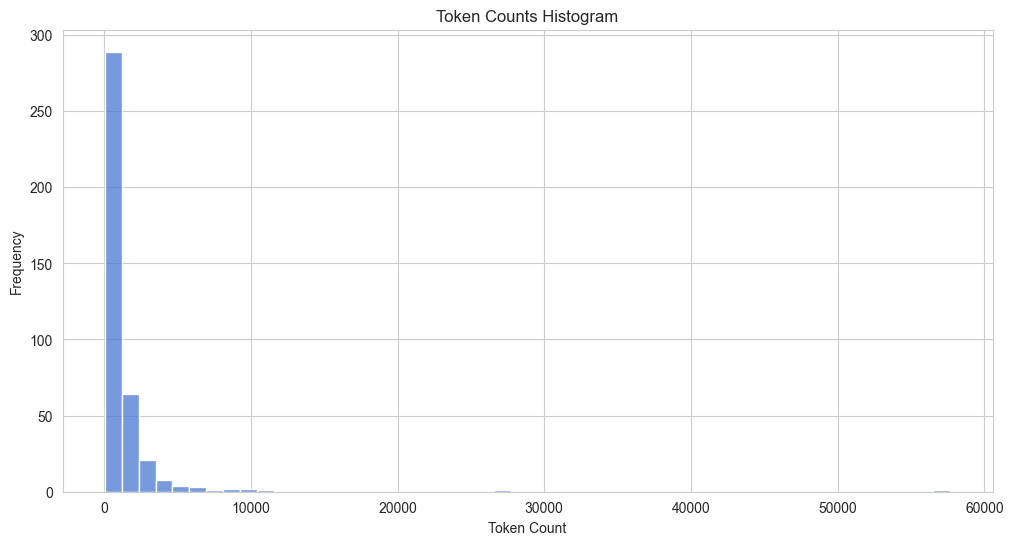

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# set style and color palette for the plot
sns.set_style("whitegrid")
sns.set_palette("muted")

# create histogram
plt.figure(figsize=(12, 6))
sns.histplot(token_counts, kde=False, bins=50)

# customize the plot info
plt.title("Token Counts Histogram")
plt.xlabel("Token Count")
plt.ylabel("Frequency")

plt.show()

The vast majority of pages seem to contain a lower number of tokens. But our limits for the number of tokens to add to each chunk is actually smaller than some of the smaller pages. But, how do we decide what this number should be?

### Chunking the Text

At the time of writing, `gpt-3.5-turbo` supports a context window of 4096 tokens — that means that input tokens + generated ( / completion) output tokens, cannot total more than 4096 without hitting an error.

So we 100% need to keep below this. If we assume a very safe margin of ~2000 tokens for the input prompt into `gpt-3.5-turbo`, leaving ~2000 tokens for conversation history and completion.

With this ~2000 token limit we may want to include *five* snippets of relevant information, meaning each snippet can be no more than **400** token long.

To create these snippets we use the `RecursiveCharacterTextSplitter` from LangChain. To measure the length of snippets we also need a *length function*. This is a function that consumes text, counts the number of tokens within the text (after tokenization using the `gpt-3.5-turbo` tokenizer), and returns that number. We define it like so:

With the length function defined we can initialize our `RecursiveCharacterTextSplitter` object like so:

In [20]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=400,
    chunk_overlap=20,  # number of tokens overlap between chunks
    length_function=tiktoken_len,
    separators=['\n\n', '\n', ' ', '']
)

Then we split the text for a document like so:

In [21]:
chunks = text_splitter.split_text(docs[5].page_content)
len(chunks)

4

In [27]:
for chunk in chunks:
    print(len(chunk.split(' ')), tiktoken_len(chunk))
# tiktoken_len(chunks[0]), tiktoken_len(chunks[1])

237 375
294 375
254 368
106 147


In [30]:
list(docs[0])

[('page_content',
  '.md\n.pdf\nDeployments\n Contents \nStreamlit\nGradio (on Hugging Face)\nBeam\nVercel\nSteamShip\nDeployments#\nSo you’ve made a really cool chain - now what? How do you deploy it and make it easily sharable with the world?\nThis section covers several options for that.\nNote that these are meant as quick deployment options for prototypes and demos, and not for production systems.\nIf you are looking for help with deployment of a production system, please contact us directly.\nWhat follows is a list of template GitHub repositories aimed that are intended to be\nvery easy to fork and modify to use your chain.\nThis is far from an exhaustive list of options, and we are EXTREMELY open to contributions here.\nStreamlit#\nThis repo serves as a template for how to deploy a LangChain with Streamlit.\nIt implements a chatbot interface.\nIt also contains instructions for how to deploy this app on the Streamlit platform.\nGradio (on Hugging Face)#\nThis repo serves as a temp

For `docs[5]` we created `2` chunks of token length `346` and `247`.

This is for a single document, we need to do this over all of our documents. While we iterate through the docs to create these chunks we will reformat them into a format that looks like:

```json
[
    {
        "id": "abc-0",
        "text": "some important document text",
        "source": "https://langchain.readthedocs.io/en/latest/glossary.html"
    },
    {
        "id": "abc-1",
        "text": "the next chunk of important document text",
        "source": "https://langchain.readthedocs.io/en/latest/glossary.html"
    }
    ...
]
```

The `"id"` will be created based on the URL of the text + it's chunk number.

In [32]:
import hashlib
m = hashlib.md5()  # this will convert URL into unique ID

url = docs[5].metadata['source'].replace('rtdocs\\', 'https://')
print(url)

# convert URL to unique ID
m.update(url.encode('utf-8'))
uid = m.hexdigest()[:12]
print(uid)

https://langchain.readthedocs.io\en\latest\index.html
30b694fe53d5


Then use the `uid` alongside chunk number and actual `url` to create the format needed:

In [34]:
data = [{'id': f'{uid}-{i}', 'text': chunk, 'source': url} for i, chunk in enumerate(chunks)]
data

[{'id': '30b694fe53d5-0',
  'text': '.rst\n.pdf\nWelcome to LangChain\n Contents \nGetting Started\nModules\nUse Cases\nReference Docs\nLangChain Ecosystem\nAdditional Resources\nWelcome to LangChain#\nLarge language models (LLMs) are emerging as a transformative technology, enabling\ndevelopers to build applications that they previously could not.\nBut using these LLMs in isolation is often not enough to\ncreate a truly powerful app - the real power comes when you are able to\ncombine them with other sources of computation or knowledge.\nThis library is aimed at assisting in the development of those types of applications. Common examples of these types of applications include:\n❓ Question Answering over specific documents\nDocumentation\nEnd-to-end Example: Question Answering over Notion Database\n💬 Chatbots\nDocumentation\nEnd-to-end Example: Chat-LangChain\n🤖 Agents\nDocumentation\nEnd-to-end Example: GPT+WolframAlpha\nGetting Started#\nCheckout the below guide for a walkthrough of 

Now we repeat the same logic across our full dataset:

In [37]:
len(docs)

397

In [35]:
from tqdm.auto import tqdm

documents = []

for doc in tqdm(docs):
    url = doc.metadata['source'].replace('rtdocs\\', 'https://')
    m.update(url.encode('utf-8'))
    uid = m.hexdigest()[:12]
    chunks = text_splitter.split_text(doc.page_content)
    for i, chunk in enumerate(chunks):
        documents.append({
            'id': f'{uid}-{i}',
            'text': chunk,
            'source': url
        })

len(documents)

c:\Users\matte\miniconda3\envs\ml\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 397/397 [00:04<00:00, 82.49it/s] 


2237

We're now left with `2201` documents. We can save them to a JSON lines (`.jsonl`) file like so:

In [40]:
documents[0]

{'id': '94d948fe82d2-0',
 'text': '.md\n.pdf\nDeployments\n Contents \nStreamlit\nGradio (on Hugging Face)\nBeam\nVercel\nSteamShip\nDeployments#\nSo you’ve made a really cool chain - now what? How do you deploy it and make it easily sharable with the world?\nThis section covers several options for that.\nNote that these are meant as quick deployment options for prototypes and demos, and not for production systems.\nIf you are looking for help with deployment of a production system, please contact us directly.\nWhat follows is a list of template GitHub repositories aimed that are intended to be\nvery easy to fork and modify to use your chain.\nThis is far from an exhaustive list of options, and we are EXTREMELY open to contributions here.\nStreamlit#\nThis repo serves as a template for how to deploy a LangChain with Streamlit.\nIt implements a chatbot interface.\nIt also contains instructions for how to deploy this app on the Streamlit platform.\nGradio (on Hugging Face)#\nThis repo se

In [41]:
import json

with open('train.jsonl', 'w') as f:
    for doc in documents:
        f.write(json.dumps(doc) + '\n')

To load the data from file we'd write:

In [42]:
documents = []

with open('train.jsonl', 'r') as f:
    for line in f:
        documents.append(json.loads(line))

len(documents)

2237

In [43]:
documents[0]

{'id': '94d948fe82d2-0',
 'text': '.md\n.pdf\nDeployments\n Contents \nStreamlit\nGradio (on Hugging Face)\nBeam\nVercel\nSteamShip\nDeployments#\nSo you’ve made a really cool chain - now what? How do you deploy it and make it easily sharable with the world?\nThis section covers several options for that.\nNote that these are meant as quick deployment options for prototypes and demos, and not for production systems.\nIf you are looking for help with deployment of a production system, please contact us directly.\nWhat follows is a list of template GitHub repositories aimed that are intended to be\nvery easy to fork and modify to use your chain.\nThis is far from an exhaustive list of options, and we are EXTREMELY open to contributions here.\nStreamlit#\nThis repo serves as a template for how to deploy a LangChain with Streamlit.\nIt implements a chatbot interface.\nIt also contains instructions for how to deploy this app on the Streamlit platform.\nGradio (on Hugging Face)#\nThis repo se

### (Optional) Sharing the Dataset

We've now created our dataset and you can go ahead and use it in any way you like. However, if you'd like to share the dataset, or store it somewhere that you can get easy access to later — we can use [Hugging Face Datasets Hub](https://huggingface.co/datasets).

To begin we first need to create an account by clicking the **Sign Up** button at [huggingface.co](https://huggingface.co/). Once done we click our profile button in the same location > click **New Dataset** > give it a name like *"langchain-docs"* > set the dataset to **Public** or **Private** > click **Create dataset**.